In [1]:
# Shaimae Elhajjajy
# February 9, 2024
# Run ArchR on the 10X Multiome PBMC scATAC 10K data, but use cCREs as anchors for calculating scATAC fragment counts.
# Note: For this run, in addPeakMatrix use a ceiling of 10^9 (which matches the feature matrix) instead of 4 (the default) to test whether it affects Scrublet and overall results.
# Note: For this run, run Scrublet with TileMatrix (doesn't work properly for PeakMatrix anyways; either low correlation between UMAPs, or error message due to bug)
# Note: Run with singularity image archr_seuratv5.sif

In [2]:
# Libraries
library(ArchR)
library(BSgenome)
library(data.table)
library(GenomicRanges)
library(Seurat)


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

In [3]:
library(ggplot2)
package.version('ggplot2')
package.version('Seurat')

[1] "3.4.4"

[1] "5.0.1"

In [4]:
# Parameters
set.seed(99)
addArchRThreads(threads = 16)

Setting default number of Parallel threads to 16.



In [5]:
# Load in custom genome
library(BSgenome.GRCh38.ENCODE, lib.loc = "/data/zusers/elhajjajys/genomes/BSgenome/GRCh38")

In [6]:
# Set location of GENCODE annotation
GENOMES_DIR = "/data/zusers/elhajjajys/genomes"
GTF_BASE = "gencode.v40.basic.annotation"

In [7]:
# Read in blacklisted regions (i.e., exclusion set)
# Note: this is the official ENCODE blacklist for hg38, and is also built-in to Signac.
blacklist_df = fread(paste0(GENOMES_DIR, "/GRCh38.ENCODE.blacklist.ENCFF356LFX.bed"), sep = "\t")
colnames(blacklist_df) = c("chr", "start", "end")
blacklist_gr = makeGRangesFromDataFrame(blacklist_df, keep.extra.columns = TRUE)

In [8]:
# Create genome annotation (to infer chromosome sizes)
genomeAnnotation <- createGenomeAnnotation(genome = BSgenome.GRCh38.ENCODE, blacklist = blacklist_gr)

Getting genome..

Attempting to infer chromSizes..

Using provided blacklist...



In [9]:
# Create general gene reference (all genes)
genes_df = fread(paste0(GENOMES_DIR, "/", GTF_BASE, "/", GTF_BASE, ".gene.bed"), sep = "\t")
colnames(genes_df) = c("chr", "start", "end", "filler1", "filler2", "strand", "symbol", "gene_name", "gene_type", 
                       "transcript_id", "transcript_name", "transcript_type")
genes_gr = makeGRangesFromDataFrame(genes_df, keep.extra.columns = TRUE)

exons_df = fread(paste0(GENOMES_DIR, "/", GTF_BASE, "/", GTF_BASE, ".exon.bed"), sep = "\t")
colnames(exons_df) = c("chr", "start", "end", "filler1", "filler2", "strand", "symbol", "gene_name", "gene_type", 
                       "transcript_id", "transcript_name", "transcript_type")
exons_gr = makeGRangesFromDataFrame(exons_df, keep.extra.columns = TRUE)

tss_df = fread(paste0(GENOMES_DIR, "/", GTF_BASE, "/", GTF_BASE, ".TSS.bed"), sep = "\t")
colnames(tss_df) = c("chr", "start", "end", "filler1", "filler2", "strand", "symbol", "gene_name", "gene_type", 
                       "transcript_id", "transcript_name", "transcript_type")
tss_gr = makeGRangesFromDataFrame(tss_df, keep.extra.columns = TRUE)

geneAnnotation <- createGeneAnnotation(
  TSS = tss_gr,
  exons = exons_gr,
  genes = genes_gr
)

In [10]:
print(paste0(nrow(genes_df), " genes, ", nrow(exons_df), " exons, ", nrow(tss_df), " TSSs."))

[1] "61544 genes, 820605 exons, 114816 TSSs."


In [11]:
# Set directory where data is located
WORKING_DIR = "/zata/zippy/phanh/encode/snMultiome/adult_heart"
DATA_DIR = paste0(WORKING_DIR, "/snATAC/bams")
# Set output directory
OUT_DIR = paste0(WORKING_DIR, "/anchored_on_cCREs_w_integration") 

In [12]:
sampleNames <- list.files(path = paste0(DATA_DIR, "/bySamples"), pattern="\\ENCSR681OLJ.bam$")
inputFiles <- paste0(DATA_DIR, "/bySamples/", sampleNames)
inputFiles
sampleNames <- sub(".bam", "", sampleNames)
sampleNames

[1] "/zata/zippy/phanh/encode/snMultiome/adult_heart/snATAC/bams/bySamples/ENCSR681OLJ.bam"

[1] "ENCSR681OLJ"

In [15]:
# Read in data and create arrow files
# Note: cell filtering at this stage is INDEPENDENT of regions (tiles vs. cCREs); 
# just need enrichment around annotated TSSs to be at least 4, and # unique fragments to be at least 1000

# bamFlag = list(isPaired = TRUE, isProperPair = TRUE, isUnmappedQuery = FALSE,  hasUnmappedMate = FALSE, 
#                isMinusStrand = TRUE, isMateMinusStrand = NA, isFirstMateRead = NA, isSecondMateRead = NA, 
#                isSecondaryAlignment = FALSE, isNotPassingQualityControls = FALSE, isDuplicate = FALSE)

ArrowFiles <- createArrowFiles(
  inputFiles = inputFiles,
  sampleNames = sampleNames,
  minTSS = 4, #Dont set this too high because you can always increase later
  minFrags = 1000, 
  addTileMat = TRUE,
  addGeneScoreMat = TRUE,
  genomeAnnotation = genomeAnnotation,
  geneAnnotation = geneAnnotation,
  bcTag = "CB",
  bamFlag = list(isMinusStrand = FALSE, isProperPair = TRUE, isDuplicate = FALSE),
  force = TRUE
)

Found Gene Seqnames not in GenomeAnnotation chromSizes, Removing : chrM

Found Exon Seqnames not in GenomeAnnotation chromSizes, Removing : chrM

Found TSS Seqnames not in GenomeAnnotation chromSizes, Removing : chrM

ArchR logging to : ArchRLogs/ArchR-createArrows-13d42d348a0b90-Date-2024-06-21_Time-18-38-46.143516.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

2024-06-21 18:38:46.223161 : Batch Execution w/ safelapply!, 0 mins elapsed.

(ENCSR681OLJ : 1 of 1) Determining Arrow Method to use!

2024-06-21 18:38:46.251041 : (ENCSR681OLJ : 1 of 1) Reading In Fragments from inputFiles (readMethod = bam), 0 mins elapsed.

2024-06-21 18:38:46.258059 : (ENCSR681OLJ : 1 of 1) Tabix Bam To Temporary File, 0.001 mins elapsed.

2024-06-21 18:39:50.964932 : (ENCSR681OLJ : 1 of 1) Successful creation of Temporary File, 1.079 mins elapsed.

2024-06-21 18:39:50.97192 : (ENCSR681OLJ : 1 of 1) Creating ArrowFile From Temporary File, 1.079 mins elapsed.

2024

In [16]:
# Create the ArchR project
proj_ENCSR681OLJ <- ArchRProject(
  ArrowFiles = ArrowFiles, 
  outputDirectory = paste0(OUT_DIR, "/ArchROut_ENCSR681OLJ"), # name of directory where all output files will be stored
  copyArrows = TRUE, #This is recommened so that you maintain an unaltered copy for later usage.
  geneAnnotation = geneAnnotation,
  genomeAnnotation = genomeAnnotation
)

Found Gene Seqnames not in GenomeAnnotation chromSizes, Removing : chrM

Found Exon Seqnames not in GenomeAnnotation chromSizes, Removing : chrM

Found TSS Seqnames not in GenomeAnnotation chromSizes, Removing : chrM

Validating Arrows...

Getting SampleNames...

1 


Copying ArrowFiles to Ouptut Directory! If you want to save disk space set copyArrows = FALSE

1 


Getting Cell Metadata...

1 


Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==

In [17]:
# Checkpoint! Save the ArchR project for easy loading next time
saveArchRProject(ArchRProj = proj_ENCSR681OLJ, outputDirectory = paste0(OUT_DIR, "/ArchROut_ENCSR681OLJ"), load = FALSE)

Saving ArchRProject...



In [18]:
# Read in cCREs
cCREs_df = fread("/zata/zippy/phanh/Registry/V4/GRCh38/GRCh38-cCREs.bed", sep = "\t", header = FALSE)
colnames(cCREs_df) = c("chr", "start", "end", "rDHS_ID", "cCRE_ID", "class")
cCREs_gr = makeGRangesFromDataFrame(cCREs_df, keep.extra.columns = TRUE)

In [19]:
# Add cCREs as a peak set to the ArchR project - assuming that "peak" is just regions of interest
# Chose to use peak matrix instead of feature matrix because it is more versatile for downstream analyses
proj_ENCSR681OLJ <- addPeakSet(
  ArchRProj = proj_ENCSR681OLJ,
  peakSet = cCREs_gr,
  genomeAnnotation = genomeAnnotation,
  force = FALSE
)

In [20]:
# Add peak matrix - compute scATAC fragments over cCREs
proj_ENCSR681OLJ <- addPeakMatrix(
  ArchRProj = proj_ENCSR681OLJ,
  ceiling = 10^9, # Change from default of 4 to match Feature Matrix
  binarize = FALSE, # Do not binarize! See "Modeling fragment counts improves single-cell ATAC-seq analysis" (https://www.nature.com/articles/s41592-023-02112-6) for reasons why.
  verbose = TRUE,
  threads = getArchRThreads(),
  parallelParam = NULL,
  force = TRUE,
  logFile = createLogFile("addPeakMatrix")
)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-13d42d6c4e8ca4-Date-2024-06-21_Time-18-50-39.666136.log
If there is an issue, please report to github with logFile!

2024-06-21 18:50:39.772615 : Batch Execution w/ safelapply!, 0 mins elapsed.

2024-06-21 18:50:45.605876 : Adding ENCSR681OLJ to PeakMatrix for Chr (1 of 24)!, 0.096 mins elapsed.

2024-06-21 18:51:03.055257 : Adding ENCSR681OLJ to PeakMatrix for Chr (2 of 24)!, 0.387 mins elapsed.

2024-06-21 18:51:15.701539 : Adding ENCSR681OLJ to PeakMatrix for Chr (3 of 24)!, 0.597 mins elapsed.

2024-06-21 18:51:25.244215 : Adding ENCSR681OLJ to PeakMatrix for Chr (4 of 24)!, 0.756 mins elapsed.

2024-06-21 18:51:32.706611 : Adding ENCSR681OLJ to PeakMatrix for Chr (5 of 24)!, 0.881 mins elapsed.

2024-06-21 18:51:40.639765 : Adding ENCSR681OLJ to PeakMatrix for Chr (6 of 24)!, 1.013 mins elapsed.

2024-06-21 18:51:48.968859 : Adding ENCSR681OLJ to PeakMatrix for Chr (7 of 24)!, 1.152 mins elapsed.

2024-06-21 18:51:56.946479 : Adding

In [21]:
# View available matrices to make sure cCRE matrix is successfully added
getAvailableMatrices(proj_ENCSR681OLJ)
# Checkpoint! Save the ArchR project for easy loading next time
saveArchRProject(ArchRProj = proj_ENCSR681OLJ, outputDirectory = paste0(OUT_DIR, "/ArchROut_ENCSR681OLJ"), load = FALSE)

[1] "GeneScoreMatrix" "PeakMatrix"      "TileMatrix"

Saving ArchRProject...



In [22]:
# Read in ArchR object 
proj_ENCSR681OLJ = loadArchRProject(path = paste0(WORKING_DIR, "/anchored_on_cCREs_w_integration/ArchROut_ENCSR681OLJ"), force = TRUE, showLogo = FALSE)

Successfully loaded ArchRProject!



In [23]:
# Before doublet removal
# Ridge plot, violin plot for each sample for the TSS enrichment scores
tss_ridges <- plotGroups(
    ArchRProj = proj_ENCSR681OLJ, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "TSSEnrichment",
    plotAs = "ridges"
   )
tss_violin <- plotGroups(
    ArchRProj = proj_ENCSR681OLJ, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "TSSEnrichment",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
   )
# Ridge plot, violin plot for each sample for the log10(unique nuclear fragments)
log10_nFrags_ridges <- plotGroups(
    ArchRProj = proj_ENCSR681OLJ, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "log10(nFrags)",
    plotAs = "ridges"
   )
log10_nFrags_violin <- plotGroups(
    ArchRProj = proj_ENCSR681OLJ, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "log10(nFrags)",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
   )
# print(tss_ridges)
# print(tss_violin)
# print(log10_nFrags_ridges)
# print(log10_nFrags_violin)
# save as pdf
# options(bitmapType='cairo')
plotPDF(plotList=list(tss_ridges,tss_violin,log10_nFrags_ridges,log10_nFrags_violin), name = "QC-Sample-Statistics-Before-Doublet-Removal.pdf", ArchRProj = proj_ENCSR681OLJ, addDOC = FALSE, width = 4, height = 4)

# pdf(paste0(OUT_DIR, "/ArchROut/Plots/QC-Sample-Statistics-Before-Doublet-Removal.pdf"), width = 4, height = 4)
# print(tss_ridges)
# print(tss_violin)
# print(log10_nFrags_ridges)
# print(log10_nFrags_violin)
# dev.off()

# Plotting Sample Fragment Size Distribution and TSS Enrichment Profiles
p1 <- plotFragmentSizes(ArchRProj = proj_ENCSR681OLJ)
p2 <- plotTSSEnrichment(ArchRProj = proj_ENCSR681OLJ)
plotPDF(p1,p2, name = "QC-Sample-FragSizes-TSSProfile-Before-Doublet-Removal.pdf", ArchRProj = proj_ENCSR681OLJ, addDOC = FALSE, width = 5, height = 5)

# pdf(paste0(OUT_DIR, "/ArchROut/Plots/QC-Sample-FragSizes-TSSProfile-Before-Doublet-Removal.pdf"), width = 5, height = 5)
# print(p1)
# print(p2)
# dev.off()

1 


1 


1 


1 


Plotting Ggplot!

Picking joint bandwidth of 0.917

Picking joint bandwidth of 0.917

Plotting Ggplot!

Plotting Ggplot!

Picking joint bandwidth of 0.0931

Picking joint bandwidth of 0.0931

Plotting Ggplot!

ArchR logging to : ArchRLogs/ArchR-plotFragmentSizes-13d42d222b361c-Date-2024-06-21_Time-18-54-07.463388.log
If there is an issue, please report to github with logFile!

2024-06-21 18:54:07.552313 : ENCSR681OLJ Computing FragmentSizes (1 of 1)!, 0.001 mins elapsed.

2024-06-21 18:54:51.302842 : ENCSR681OLJ Finished Computing FragmentSizes (1 of 1)!, 0.731 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotFragmentSizes-13d42d222b361c-Date-2024-06-21_Time-18-54-07.463388.log

ArchR logging to : ArchRLogs/ArchR-plotTSSEnrichment-13d42d3b22bdfe-Date-2024-06-21_Time-18-54-51.339329.log
If there is an issue, please report to github with logFile!

2024-06-21 18:54:51.771948 : ENCSR681OLJ Computing TSS (1 of 1)!, 0.007 mins elapsed.

2024-06-21 18:56:45

In [24]:
# Compute doublet scores (use "peaks", or cCREs to define doublets)
proj_ENCSR681OLJ <- addDoubletScores(
  input = proj_ENCSR681OLJ,
  useMatrix = "PeakMatrix",
  k = 10, #Refers to how many cells near a "pseudo-doublet" to count.
  knnMethod = "UMAP", #Refers to the embedding to use for nearest neighbor search.
  LSIMethod = 1,
  LSIParams = list(iterations = 2, 
                   clusterParams = list( #See Seurat::FindClusters
                                       resolution = c(0.2), 
                                       # sampleCells = 10000, 
                                       n.start = 10), 
                   varFeatures = 50000, 
                   dimsToUse = 1:30,
                   force = T)
)

ArchR logging to : ArchRLogs/ArchR-addDoubletScores-13d42d21ce0c5e-Date-2024-06-21_Time-18-56-48.582837.log
If there is an issue, please report to github with logFile!

2024-06-21 18:56:48.669112 : Batch Execution w/ safelapply!, 0 mins elapsed.

2024-06-21 18:56:48.676767 : ENCSR681OLJ (1 of 1) :  Computing Doublet Statistics, 0 mins elapsed.

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

ENCSR681OLJ (1 of 1) : UMAP Projection R^2 = 0.00104

ENCSR681OLJ (1 of 1) : UMAP Projection R^2 = 0.00104

ENCSR681OLJ (1 of 1) : Correlation of UMAP Projection is below 0.9 (normally this is ~0.99)
This means there is little heterogeneity in your sample and thus doubletCalling is inaccurate.
force = FALSE, thus returning -1 doubletScores and doubletEnr

In [25]:
# View cCRE x fragment count peak matrix
cCRE_peak_matrix <- getMatrixFromProject(
  ArchRProj = proj_ENCSR681OLJ,
  useMatrix = "PeakMatrix",
  useSeqnames = NULL,
  verbose = TRUE,
  binarize = FALSE,
  threads = getArchRThreads(),
  logFile = createLogFile("getMatrixFromProject")
)
# Set rownames to cCRE IDs
rownames(cCRE_peak_matrix) = cCREs_df$cCRE_ID

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-13d42d6ec7e5d9-Date-2024-06-21_Time-19-02-12.477786.log
If there is an issue, please report to github with logFile!

2024-06-21 19:03:36.736919 : Organizing colData, 1.404 mins elapsed.

2024-06-21 19:03:36.739944 : Organizing rowData, 1.404 mins elapsed.

2024-06-21 19:03:36.744952 : Organizing rowRanges, 1.404 mins elapsed.

2024-06-21 19:03:36.753426 : Organizing Assays (1 of 1), 1.405 mins elapsed.

2024-06-21 19:03:36.760041 : Constructing SummarizedExperiment, 1.405 mins elapsed.

2024-06-21 19:04:00.093141 : Finished Matrix Creation, 1.794 mins elapsed.



In [26]:
# View dimensions of the matrix (# cCREs vs. # cells)
print("cCRE matrix dimensions:")
print(dim(cCRE_peak_matrix))
# View attributes per cell (including doublet scores)
cat("\ncCRE matrix column data:\n")
print(colData(cCRE_peak_matrix))
# View the (sparse) cCRE matrix (fragment counts over cCREs) to make sure it is successfully populated
cat("\ncCRE matrix:\n")
print(assays(cCRE_peak_matrix)$PeakMatrix)

[1] "cCRE matrix dimensions:"
[1] 2348854   10095

cCRE matrix column data:
DataFrame with 10095 rows and 17 columns
                                   BlacklistRatio DoubletEnrichment
                                          <array>           <array>
ENCSR681OLJ#GGCTTCATGGATGTAG  0.00705800210475188                -1
ENCSR681OLJ#CGTATTTGATTATCAC  0.00870454919381375                -1
ENCSR681OLJ#TAGGTTTCTGGTCTTA  0.00516290888730969                -1
ENCSR681OLJ#GGTTGTTCTTGCGTGT  0.00965152506292063                -1
ENCSR681OLJ#CAGCAAGTGCACCTTC  0.00621556553544146                -1
...                                           ...               ...
ENCSR681OLJ#GCAAATACTGGAAGCT   0.0804195804195804                -1
ENCSR681OLJ#GGCAATATGCAAGCGA 0.000999000999000999                -1
ENCSR681OLJ#TCGTCCTTGAGCTTGC   0.0889110889110889                -1
ENCSR681OLJ#TGGCTCACTCTAGCTG   0.0124875124875125                -1
ENCSR681OLJ#AGGTTATGACCAAATG                0.005                -1

  [[ suppressing 31 column names ‘ENCSR681OLJ#GGCTTCATGGATGTAG’, ‘ENCSR681OLJ#CGTATTTGATTATCAC’, ‘ENCSR681OLJ#TAGGTTTCTGGTCTTA’ ... ]]

  [[ suppressing 31 column names ‘ENCSR681OLJ#GGCTTCATGGATGTAG’, ‘ENCSR681OLJ#CGTATTTGATTATCAC’, ‘ENCSR681OLJ#TAGGTTTCTGGTCTTA’ ... ]]



                                                                                  
EH38E2776516 . . . . . . . . . . . . . . . . . . .  . . . . . . . . . . . . ......
EH38E2776517 . . . . . 1 . 4 . . . . . . . . . 2 .  . 2 . . . . . 2 . . . . ......
EH38E3951272 . . . . . . . . . . . . . . . . . . .  . . . . . . . . . . . . ......
EH38E3951273 . . . . . . . . . . . . . . . . . . .  . . . . . . . . . . . . ......
EH38E3951274 . . . . . . . . . . . . . . . . . . .  . . . . . . . . . . . . ......
EH38E3951275 . . . . . . . . . . . . . . . . . . .  . . . . . . . . . . . . ......
EH38E3951276 . . . . . . . . . . . . . . . . . . .  . . . . . . . . . . . . ......
EH38E2776519 . . . . . . . . . . . . . . . . . . .  . . . . . . . . . . . . ......
EH38E3951277 . . . . . . . . . . . . . . . . . . .  . . . . . . . . . . . . ......
EH38E3951278 . . . . . . . . . . . . . . . . . . .  . . . . . . . . . . . . ......
EH38E3951279 . . . . . . . . . . . . . . . . . . .  . . . . . . . . . . . . ......
EH38

  [[ suppressing 31 column names ‘ENCSR681OLJ#GGCTTCATGGATGTAG’, ‘ENCSR681OLJ#CGTATTTGATTATCAC’, ‘ENCSR681OLJ#TAGGTTTCTGGTCTTA’ ... ]]



                                                                                 
EH38E3950729 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
EH38E3950730 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
EH38E4534502 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
EH38E2775687 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
EH38E3950731 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
EH38E3950732 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
EH38E4534503 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
EH38E4534504 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
EH38E4534505 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
EH38E4534506 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
EH38E4534507 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......
EH38E3950733 . .

In [27]:
# Filter out doublets based on the previously calculated doublet scores
proj_ENCSR681OLJ <- filterDoublets(proj_ENCSR681OLJ)

Filtering 0 cells from ArchRProject!

	ENCSR681OLJ : 0 of 10095 (0%)



In [28]:
### Plot QC metrics
# TSS enrichment as ridge plot
tss_enrich_ridge <- plotGroups(
    ArchRProj = proj_ENCSR681OLJ, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "TSSEnrichment",
    plotAs = "ridges"
   )
# TSS enrichment as violin plot
tss_enrich_violin <- plotGroups(
    ArchRProj = proj_ENCSR681OLJ, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "TSSEnrichment",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
   )
# # fragments as ridge plot
num_fragments_ridge <- plotGroups(
    ArchRProj = proj_ENCSR681OLJ, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "log10(nFrags)",
    plotAs = "ridges"
   )
# # fragments as violin plot
num_fragments_violin <- plotGroups(
    ArchRProj = proj_ENCSR681OLJ, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "log10(nFrags)",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
   )
plotPDF(tss_enrich_ridge, tss_enrich_violin, num_fragments_ridge, num_fragments_violin, 
        name = "QC-Sample-Statistics.pdf", ArchRProj = proj_ENCSR681OLJ, addDOC = FALSE, width = 4, height = 4)

1 


1 


1 


1 


Plotting Ggplot!

Picking joint bandwidth of 0.879

Picking joint bandwidth of 0.879

Plotting Ggplot!

Plotting Ggplot!

Picking joint bandwidth of 0.0864

Picking joint bandwidth of 0.0864

Plotting Ggplot!



In [29]:
### Plot QC metrics
# fragment size
fragment_size <- plotFragmentSizes(ArchRProj = proj_ENCSR681OLJ)
# TSS enrichment
tss_enrich <- plotTSSEnrichment(ArchRProj = proj_ENCSR681OLJ)
plotPDF(fragment_size, tss_enrich, name = "QC-Sample-FragSizes-TSSProfile.pdf", ArchRProj = proj_ENCSR681OLJ, addDOC = FALSE, width = 5, height = 5)

ArchR logging to : ArchRLogs/ArchR-plotFragmentSizes-13d42d73df83e9-Date-2024-06-21_Time-19-19-37.598437.log
If there is an issue, please report to github with logFile!

2024-06-21 19:19:37.689954 : ENCSR681OLJ Computing FragmentSizes (1 of 1)!, 0.002 mins elapsed.

2024-06-21 19:20:10.223439 : ENCSR681OLJ Finished Computing FragmentSizes (1 of 1)!, 0.544 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotFragmentSizes-13d42d73df83e9-Date-2024-06-21_Time-19-19-37.598437.log

ArchR logging to : ArchRLogs/ArchR-plotTSSEnrichment-13d42d68993f69-Date-2024-06-21_Time-19-20-10.253037.log
If there is an issue, please report to github with logFile!

2024-06-21 19:20:10.693735 : ENCSR681OLJ Computing TSS (1 of 1)!, 0.007 mins elapsed.

2024-06-21 19:21:51.967587 : ENCSR681OLJ Finished Computing TSS (1 of 1)!, 1.695 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotTSSEnrichment-13d42d68993f69-Date-2024-06-21_Time-19-20-10.253037.log

Plotting Ggplot!

Plotting Ggplo

In [30]:
# Checkpoint! Save the ArchR project for easy loading next time
saveArchRProject(ArchRProj = proj_ENCSR681OLJ, outputDirectory = paste0(OUT_DIR, "/ArchROut_ENCSR681OLJ"), load = FALSE)

Saving ArchRProject...



In [31]:
# Perform dimensionality reduction using the cCRE Matrix
proj_ENCSR681OLJ <- addIterativeLSI(
    ArchRProj = proj_ENCSR681OLJ,
    useMatrix = "PeakMatrix", 
    name = "IterativeLSI", 
    iterations = 2, 
    clusterParams = list( #See Seurat::FindClusters
        resolution = c(0.2), 
        sampleCells = 10000, 
        n.start = 10
    ), 
    varFeatures = 25000, 
    dimsToUse = 1:30
)

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-13d42d15fcbec1-Date-2024-06-21_Time-19-22-06.827899.log
If there is an issue, please report to github with logFile!

2024-06-21 19:22:06.968796 : Computing Total Across All Features, 0.001 mins elapsed.

2024-06-21 19:22:12.925867 : Computing Top Features, 0.1 mins elapsed.

###########
2024-06-21 19:22:15.132836 : Running LSI (1 of 2) on Top Features, 0.137 mins elapsed.
###########

2024-06-21 19:22:15.203644 : Sampling Cells (N = 10000) for Estimated LSI, 0.138 mins elapsed.

2024-06-21 19:22:15.206025 : Creating Sampled Partial Matrix, 0.138 mins elapsed.

2024-06-21 19:22:29.643164 : Computing Estimated LSI (projectAll = FALSE), 0.379 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

2024-06-21 19:23:17.737294 : Identifying Clusters, 1.18 mins elapsed.

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
2024-06-21 19:23:28.981704 : Identified 6 Clusters, 1.368 mins elapsed.


In [32]:
# Perform clustering using the cCRE Matrix
proj_ENCSR681OLJ <- addClusters(
    input = proj_ENCSR681OLJ,
    reducedDims = "IterativeLSI",
    method = "Seurat",
    name = "Clusters",
    resolution = 0.8
)

ArchR logging to : ArchRLogs/ArchR-addClusters-13d42d25fb9f0d-Date-2024-06-21_Time-19-24-58.566036.log
If there is an issue, please report to github with logFile!

2024-06-21 19:24:58.733192 : Running Seurats FindClusters (Stuart et al. Cell 2019), 0.002 mins elapsed.

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10095
Number of edges: 420347

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8754
Number of communities: 19
Elapsed time: 0 seconds


1 singletons identified. 18 final clusters.

2024-06-21 19:25:11.044712 : Testing Biased Clusters, 0.207 mins elapsed.

2024-06-21 19:25:11.072101 : Testing Outlier Clusters, 0.207 mins elapsed.

2024-06-21 19:25:11.07657 : Assigning Cluster Names to 18 Clusters, 0.207 mins elapsed.

2024-06-21 19:25:11.18451 : Finished addClusters, 0.209 mins elapsed.



In [33]:
# Perform embedding using the cCRE Matrix
proj_ENCSR681OLJ <- addUMAP(
    ArchRProj = proj_ENCSR681OLJ, 
    reducedDims = "IterativeLSI", 
    name = "UMAP", 
    nNeighbors = 30, 
    minDist = 0.4, 
    metric = "cosine",
    force = TRUE
)

19:25:11 UMAP embedding parameters a = 0.7669 b = 1.223

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

19:25:11 Read 10095 rows and found 30 numeric columns

19:25:11 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

19:25:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:25:14 Writing NN index file to temp file /tmp/Rtmp2GwwL9/file13d42d7fd36d6b

19:25:14 Searching Annoy index using 16 threads, search_k = 3000

19:25:14 Annoy recall = 100%

19:25:17 Commencing smooth kNN distance calibration using 16 threads
 with target n_neighbors = 30

19:25:19 Initializing from normalized Laplac

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-13d42d525bfe4e-Date-2024-06-21_Time-19-25-26.749738.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-13d42d525bfe4e-Date-2024-06-21_Time-19-25-26.749738.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-13d42d3e878aac-Date-2024-06-21_Time-19-25-27.013389.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-13d42d3e878aac-Date-2024-06-21_Time-19-25-27.013389.log

Plotting Ggplot!

Plotting Ggplot!



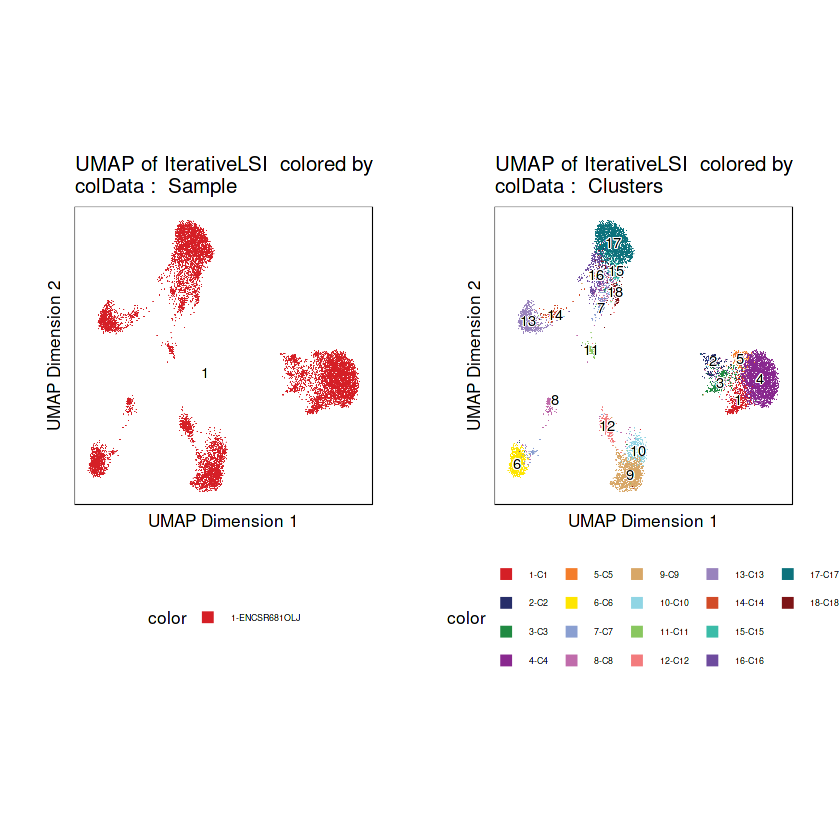

In [34]:
p1 <- plotEmbedding(ArchRProj = proj_ENCSR681OLJ, colorBy = "cellColData", name = "Sample", embedding = "UMAP")
p2 <- plotEmbedding(ArchRProj = proj_ENCSR681OLJ, colorBy = "cellColData", name = "Clusters", embedding = "UMAP")
ggAlignPlots(p1, p2, type = "h")
plotPDF(p1,p2, name = "Plot-UMAP-Sample-Clusters.pdf", ArchRProj = proj_ENCSR681OLJ, addDOC = FALSE, width = 5, height = 5)

In [35]:
# Checkpoint! Save the ArchR project for easy loading next time
saveArchRProject(ArchRProj = proj_ENCSR681OLJ, outputDirectory = paste0(OUT_DIR, "/ArchROut_ENCSR681OLJ"), load = FALSE)

Saving ArchRProject...



In [40]:
# # Identify marker features to differentiate between clusters
markersGS <- getMarkerFeatures(
    ArchRProj = proj_ENCSR681OLJ, 
    useMatrix = "GeneScoreMatrix", 
    groupBy = "Clusters",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = "wilcoxon"
)

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-13d42d227ec956-Date-2024-06-21_Time-19-59-18.727482.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Double.Matrix

2024-06-21 19:59:19.30716 : Matching Known Biases, 0.007 mins elapsed.

###########
2024-06-21 20:01:22.11561 : Completed Pairwise Tests, 2.054 mins elapsed.
###########

ArchR logging successful to : ArchRLogs/ArchR-getMarkerFeatures-13d42d227ec956-Date-2024-06-21_Time-19-59-18.727482.log



In [41]:
# # Get markers
markerList <- getMarkers(markersGS, cutOff = "FDR <= 0.01 & Log2FC >= 1.25")
markerList

List of length 18
names(18): C1 C2 C3 C4 C5 C6 C7 C8 C9 C10 C11 C12 C13 C14 C15 C16 C17 C18

In [42]:
# sum(which(genes_df[genes_df$symbol %in% markerList$C14$name,]$gene_type == "lncRNA"))

In [43]:
# # Checkpoint! Save the ArchR project for easy loading next time
saveArchRProject(ArchRProj = proj_ENCSR681OLJ, outputDirectory = paste0(OUT_DIR, "/ArchROut_ENCSR681OLJ"), load = FALSE)

Saving ArchRProject...



In [44]:
# Set known marker genes
markerGenes  <- c(
    # Fibroblast
    "DCN", "LUM", "PODN",
    # Macrophages
    "C1QB", "CD163", "MS4A7",
    # Endothelial
    "EGFL7", "CLDN5", "VWF",
    # Smooth muscle cells
    "GJA4", "FOXL1", "CARMN",
    # Vascular smooth muscle cells
    "FOXC2", "MYLK",
    # T lymphocytes
    "IFNG", "CD3D", "GZMA",
    # Schwann cells
    "S100B", "SOX10", "PLP1",
    # B lymphocytes
    "IGHJ6", "IGHA1", "IGHA2",
    # Mast cells
    "GATA1", "MRGPRX2", "HDC",
    # Mesothelial cells
    "HAS1", "WT1",
    # Adipocytes
    "ADIPOQ", "CIDEC", "LEP", "SLC36A2", "P2RX5", "UCP1", "CIDEA", "PRDM16", "LHX8", "EPSTI1", "MC2R", "FFAR2", "PIKFYVE", "CYP11B2",
    "TLR2", "TLR4", "ADRB1", "ADRB2", "ADRB3", "FABP4", "TNFRSF9", "TBX1", "TMEM26", "TCF21", "ADIPOQ", "CFD", "ACVR1C", "SLC2A4",
    "LPIN1", "PLIN1", "PCK1", "PPARG", "RETN", "MEST", "ADM2", "STAT6", "TFE3", "CPPED1", "SLC1A5", "ACSL1", "CAR3", "CAVIN1", "AGT",
    "BCAT2", "PNPLA2", "CIDEC", "CDO1", "APOC1", "MMP2", "POSTN", "LOX", "COL6A2", "ZBTB16", "GULP1", "FZD4", "TRIP10", "FGF7", "MAOB",
    "SOCS1", "NNMT", "AOC3", "H6PD", "CYP27A1", "EBF2", "MNDA", "HSD11B1", "AR", "GDF10", "CYP1B1", "STEAP4", "CCL11", "DEPTOR", "TUSC5",
    "FMO1", "ACADSB", "XDH", "PTGES", "CREB3L1", "ANGPTL2", "ADH1", "LBP", "NMB", "RARRES2", "EGFR", "CPXM1", "C3", "ADAMTS5", "MT2A",
    "METRN", "METRNL", "MYO1C", "NQO1", "AQP5", "TSPO", "AZGP1", "LRP1", "PDE3B", "LGALS12", "SERPINF1", "CPT1B", "ELOVL3", "PPARGC1A", 
    "MPZL1", "CITED1", "DPT", "HOXC9", "ZNF423", "ESM1",
    # Cardiomyocytes
    "TNNT2", "NKX2-5", "NPPA", "TNNC1", "ADM2", "ALCAM", "NPPA", "FGF2", "NPPB", "TNNI3", "TNNT2", "ANKRD1", "NPPC", "DES", "HAND2", "HAND1",
    "GATA4", "GATA6", "MYL2", "PNMT", "ACTA1", "CD36", "VLDLR", "ALPK3", "RBM24", "FABP4", "CKMT2", "MYH7B", "MYOM2", "PDLIM5", "MYH7", "PLN",
    "TCAP", "SORBS2", "RYR2", "ACTC1", "MYL3", "PDE3D", "NEXN", "FHL2", "MYBPC3", "MYH6", "TTN", "GPIHBP1", "AQP1", "DMD", "MFN2", "ASB2", "ART3",
    "RRAD", "JPH2", "HSPB7", "MYOZ2", "ENO3", "TRDN", "ACTN2", "TNNI1", "SMPX", "MYL7", "TBX20", "TRIM63", "MB", "CTGF", "MYL4", "LOX", "CTNNB1",
    "CPT1A", "SOX18", "NOTCH1", "SLN", "CSRP3", "TXLNB", "ATP2A2", "CKMT2", "CKB", "CXCR4", "IL11RA", "MITF", "ZFPM2", "BDNF", "GJA5", "FMOD",
    "MTTP", "SLC5A1", "ADIPOQ", "TRPV1", "HAMP", "SGPL1", "HMGB2", "STC1", "FGF23", "STRN", "HEY2", "ADIPOR1", "ADIPOR2", "PDE1A", "BMP4", "CASQ2", "TMP1",
    # Adipocytes progenitor cells
    "FGF10", "WT1", "SCARA5", "HOXC8", "TCF7L1", "HOXC9", "EBF2", "NRG4",
    # Cardiac stem and precursor cells
    "NKX2-5", "ISL1", "MESP1", "ADGRL2", "TBX3", "TBX4", "WNT5A", "ANKRD1"
    
    
    
  )
markerGenes = unique(markerGenes)
markerGenes_geneIDs = genes_df[genes_df$gene_name %in% markerGenes,]$symbol
markerGenes_geneIDs = markerGenes_geneIDs[!grepl("PAR_Y", markerGenes_geneIDs)]

ArchR logging to : ArchRLogs/ArchR-plotMarkerHeatmap-13d42d14b60ff5-Date-2024-06-21_Time-20-01-37.776183.log
If there is an issue, please report to github with logFile!

Printing Top Marker Genes:

C1:

	ENSG00000162594.16, ENSG00000288736.1, ENSG00000156869.14, ENSG00000266144.1, ENSG00000229220.1, ENSG00000067057.18, ENSG00000273001.1, ENSG00000229644.6, ENSG00000266524.3, ENSG00000270192.1, ENSG00000232936.6, ENSG00000225836.1, ENSG00000207068.1, ENSG00000265258.1, ENSG00000167311.14

C2:

	ENSG00000183072.10, ENSG00000187642.10, ENSG00000242590.1, ENSG00000162571.14, ENSG00000205231.1, ENSG00000186827.11, ENSG00000179403.12, ENSG00000225285.1, ENSG00000189409.14, ENSG00000187730.9, ENSG00000157873.18, ENSG00000228037.1, ENSG00000177133.13, ENSG00000142611.17, ENSG00000226286.1

C3:

	ENSG00000187642.10, ENSG00000242590.1, ENSG00000162571.14, ENSG00000205231.1, ENSG00000186827.11, ENSG00000179403.12, ENSG00000225285.1, ENSG00000189409.14, ENSG00000187730.9, ENSG00000157873.18, ENSG0

  [1] "ENSG00000142611.17" "ENSG00000049249.9"  "ENSG00000049239.13"
  [4] "ENSG00000175206.11" "ENSG00000120937.9"  "ENSG00000116688.18"
  [7] "ENSG00000173641.18" "ENSG00000173369.18" "ENSG00000158022.7" 
 [10] "ENSG00000187513.9"  "ENSG00000174348.14" "ENSG00000162624.16"
 [13] "ENSG00000162614.19" "ENSG00000117114.21" "ENSG00000118729.12"
 [16] "ENSG00000265107.3"  "ENSG00000163563.8"  "ENSG00000197965.12"
 [19] "ENSG00000143196.5"  "ENSG00000010932.17" "ENSG00000118194.21"
 [22] "ENSG00000159173.19" "ENSG00000159346.13" "ENSG00000122176.12"
 [25] "ENSG00000117594.10" "ENSG00000143632.15" "ENSG00000135744.9" 
 [28] "ENSG00000077522.15" "ENSG00000198626.18" "ENSG00000266524.3" 
 [31] "ENSG00000196932.12" "ENSG00000166224.17" "ENSG00000148677.7" 
 [34] "ENSG00000119915.5"  "ENSG00000043591.6"  "ENSG00000196177.13"
 [37] "ENSG00000177666.17" "ENSG00000152270.9"  "ENSG00000183695.3" 
 [40] "ENSG00000129170.10" "ENSG00000176697.20" "ENSG00000184937.16"
 [43] "ENSG00000157613.11" "ENSG00

Adding Annotations..

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotMarkerHeatmap-13d42d14b60ff5-Date-2024-06-21_Time-20-01-37.776183.log

Plotting ComplexHeatmap!



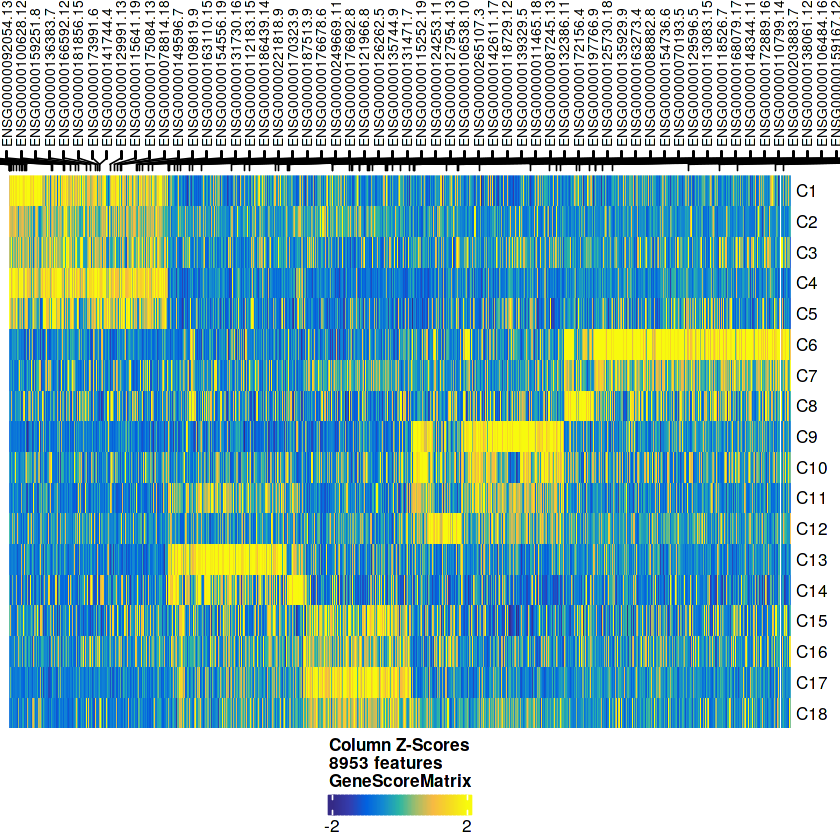

In [45]:
# # Plot a heatmap of marker genes
heatmapGS <- plotMarkerHeatmap(
  seMarker = markersGS, 
  cutOff = "FDR <= 0.01 & Log2FC >= 1.25", 
  labelMarkers = markerGenes_geneIDs,
  transpose = TRUE
)
ComplexHeatmap::draw(heatmapGS, heatmap_legend_side = "bot", annotation_legend_side = "bot")
plotPDF(heatmapGS, name = "GeneScores-Marker-Heatmap", width = 8, height = 6, ArchRProj = proj_ENCSR681OLJ, addDOC = FALSE)

In [46]:
# # Impute weights with MAGIC
proj_ENCSR681OLJ <- addImputeWeights(proj_ENCSR681OLJ)

ArchR logging to : ArchRLogs/ArchR-addImputeWeights-13d42d51498014-Date-2024-06-21_Time-20-01-49.055176.log
If there is an issue, please report to github with logFile!

2024-06-21 20:01:49.112874 : Computing Impute Weights Using Magic (Cell 2018), 0 mins elapsed.



Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-13d42d51685acb-Date-2024-06-21_Time-20-02-03.979621.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2024-06-21 20:02:04.192454 : 

1 


Imputing Matrix

Using weights on disk

Using weights on disk

Plotting Embedding

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
39 
40 
41 
42 
43 
44 
45 
46 
47 
48 
49 
50 
51 
52 
53 
54 
55 
56 
57 
58 
59 
60 
61 
62 
63 
64 
65 
66 
67 
68 
69 
70 
71 
72 
73 
74 
75 
76 
77 
78 
79 
80 
81 
82 
83 
84 
85 
86 
87 
88 
89 
90 
91 
92 
93 
94 
95 
96 
97 
98 
99 
100 
101 
102 
103 
104 
105 
106 
107 
108 
109 
110 
111 
112 
113 
114 
115 
116 
117 
118 
119 
120 
121 
122 
123 
124 
125 
126 
127 
128 
129 
130 
131 
132 
133 
134 
135 
136 
137 
138 
139 
140 
141 
142 
143 
144 
145

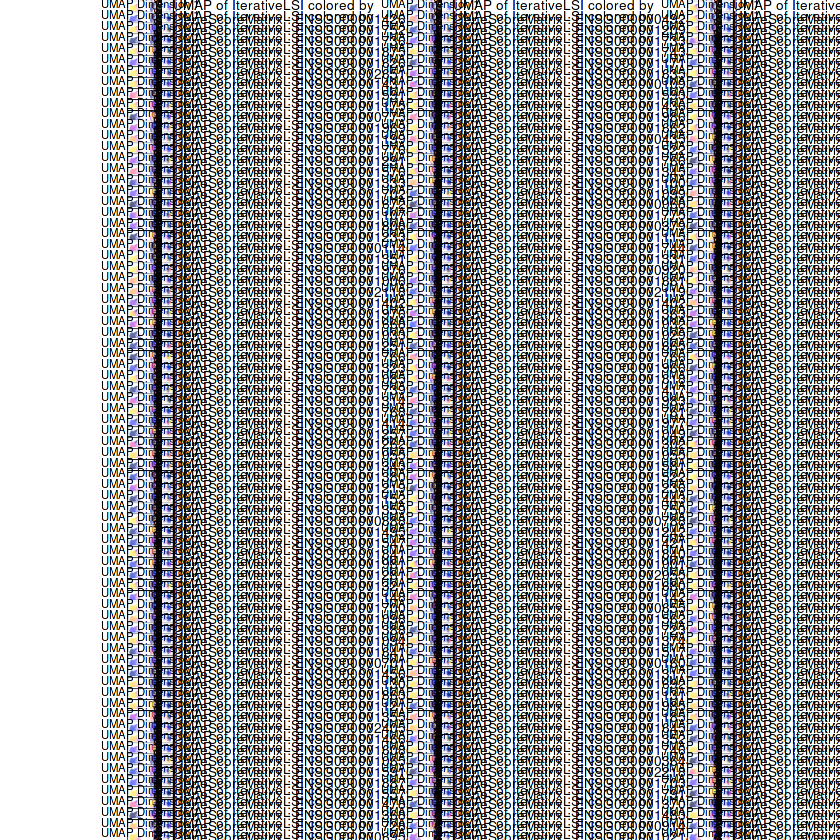

In [47]:
# Overlay marker gene score on the embedding
p <- plotEmbedding(
    ArchRProj = proj_ENCSR681OLJ, 
    colorBy = "GeneScoreMatrix", 
    name = markerGenes_geneIDs, 
    embedding = "UMAP",
    imputeWeights = getImputeWeights(proj_ENCSR681OLJ)
)
#Rearrange for grid plotting
p2 <- lapply(p, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6.5) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})
do.call(cowplot::plot_grid, c(list(ncol = 3),p2))
plotPDF(plotList = p, 
    name = "Plot-UMAP-Marker-Genes-W-Imputation.pdf", 
    ArchRProj = proj_ENCSR681OLJ, 
    addDOC = FALSE, width = 5, height = 5)

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-13d42d1bbe6798-Date-2024-06-21_Time-19-25-50.757345.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Integer.Matrix

2024-06-21 19:25:53.006967 : Matching Known Biases, 0.036 mins elapsed.

###########
2024-06-21 19:28:45.385599 : Completed Pairwise Tests, 2.909 mins elapsed.
###########

ArchR logging successful to : ArchRLogs/ArchR-getMarkerFeatures-13d42d1bbe6798-Date-2024-06-21_Time-19-25-50.757345.log



DataFrame with 5767 rows and 7 columns
        seqnames     idx     start       end    Log2FC         FDR  MeanDiff
           <Rle> <array>   <array>   <array> <numeric>   <numeric> <numeric>
38533       chr1   38533  30756711  30757061   5.02210 3.54365e-16  0.336745
1023011    chr19   40312  39398400  39398749   4.54936 2.74754e-15  0.477711
1276830    chr20   34440  40506601  40506951   4.81296 3.37281e-15  0.356317
28494       chr1   28494  22652875  22653213   6.41121 3.89575e-13  0.302303
28483       chr1   28483  22643346  22643692   5.71203 5.23949e-13  0.241207
...          ...     ...       ...       ...       ...         ...       ...
760105     chr15   71028 101168240 101168590   2.11625  0.00981100 0.0883730
2101524     chr8   37313  47734838  47735177   2.41199  0.00981279 0.1758835
468661     chr12   35824  47741406  47741756   1.42382  0.00989111 0.0643452
2167893     chr8  103682 133919461 133919811   1.94751  0.00989816 0.1538320
1379008    chr22   41917  50190491  5

ArchR logging to : ArchRLogs/ArchR-plotMarkerHeatmap-13d42d47b740aa-Date-2024-06-21_Time-19-29-51.432379.log
If there is an issue, please report to github with logFile!

Identified 25994 markers!



  [1] "ENSG00000142611.17" "ENSG00000049249.9"  "ENSG00000049239.13"
  [4] "ENSG00000175206.11" "ENSG00000120937.9"  "ENSG00000116688.18"
  [7] "ENSG00000173641.18" "ENSG00000173369.18" "ENSG00000158022.7" 
 [10] "ENSG00000187513.9"  "ENSG00000174348.14" "ENSG00000162624.16"
 [13] "ENSG00000162614.19" "ENSG00000117114.21" "ENSG00000118729.12"
 [16] "ENSG00000265107.3"  "ENSG00000163563.8"  "ENSG00000197965.12"
 [19] "ENSG00000143196.5"  "ENSG00000010932.17" "ENSG00000118194.21"
 [22] "ENSG00000159173.19" "ENSG00000159346.13" "ENSG00000122176.12"
 [25] "ENSG00000117594.10" "ENSG00000143632.15" "ENSG00000135744.9" 
 [28] "ENSG00000077522.15" "ENSG00000198626.18" "ENSG00000266524.3" 
 [31] "ENSG00000196932.12" "ENSG00000166224.17" "ENSG00000148677.7" 
 [34] "ENSG00000119915.5"  "ENSG00000043591.6"  "ENSG00000196177.13"
 [37] "ENSG00000177666.17" "ENSG00000152270.9"  "ENSG00000183695.3" 
 [40] "ENSG00000129170.10" "ENSG00000176697.20" "ENSG00000184937.16"
 [43] "ENSG00000157613.11" "ENSG00

Adding Annotations..

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotMarkerHeatmap-13d42d47b740aa-Date-2024-06-21_Time-19-29-51.432379.log

Plotting ComplexHeatmap!



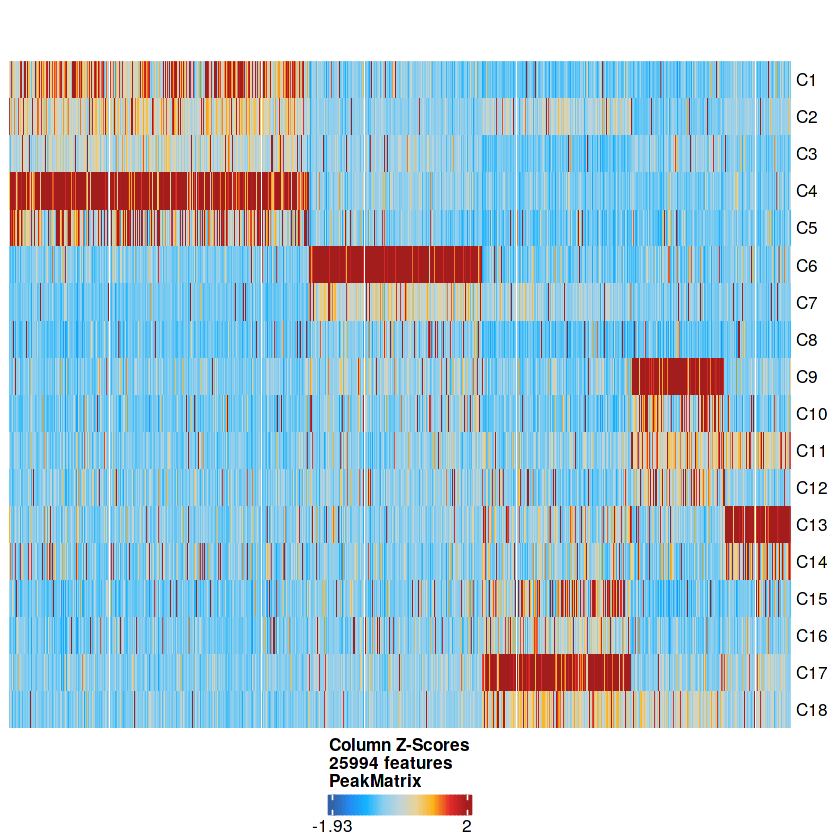

In [37]:
markersP <- getMarkerFeatures(
    ArchRProj = proj_ENCSR681OLJ, 
    useMatrix = "PeakMatrix", 
    groupBy = "Clusters",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = "wilcoxon"
)
markerListP <- getMarkers(markersP, cutOff = "FDR <= 0.01 & Log2FC >= 1.25")
markerListP$C6

#Assigning Clusters with Peaks
heatmapP <- plotMarkerHeatmap(
  seMarker = markersP, 
  cutOff = "FDR <= 0.01 & Log2FC >= 1.25", 
  labelMarkers = markerGenes_geneIDs,
  transpose = TRUE
)
ComplexHeatmap::draw(heatmapP, heatmap_legend_side = "bot", annotation_legend_side = "bot")
plotPDF(heatmapP, name = "Peaks-Marker-Heatmap", width = 8, height = 6, ArchRProj = proj_ENCSR681OLJ, addDOC = FALSE)

In [39]:
# Checkpoint! Save the ArchR project for easy loading next time
saveArchRProject(ArchRProj = proj_ENCSR681OLJ, outputDirectory = paste0(OUT_DIR, "/ArchROut_ENCSR681OLJ"), load = FALSE)

Saving ArchRProject...



In [48]:
p <- plotBrowserTrack(
    ArchRProj = proj_ENCSR681OLJ, 
    groupBy = "Clusters", 
    geneSymbol = markerGenes_geneIDs, 
    upstream = 50000,
    downstream = 50000
)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-13d42d762ecdb8-Date-2024-06-21_Time-20-09-22.566607.log
If there is an issue, please report to github with logFile!

2024-06-21 20:09:22.633219 : Validating Region, 0.001 mins elapsed.



GRanges object with 231 ranges and 8 metadata columns:
        seqnames              ranges strand |     filler1     filler2
           <Rle>           <IRanges>  <Rle> | <character> <character>
    [1]     chr1     3069167-3438621      + |           .           .
    [2]     chr1     7915870-7943165      - |           .           .
    [3]     chr1     9234773-9271337      + |           .           .
    [4]     chr1   11845708-11848345      - |           .           .
    [5]     chr1   11857463-11858945      - |           .           .
    ...      ...                 ...    ... .         ...         ...
  [227]     chrX   48786539-48794311      + |           .           .
  [228]     chrX   49028725-49043410      - |           .           .
  [229]     chrX   67544020-67730619      + |           .           .
  [230]     chrX   72301637-72307187      - |           .           .
  [231]     chrX 103773717-103792619      + |           .           .
                    symbol   gene_n

2024-06-21 20:09:22.748224 : Adding Bulk Tracks (1 of 231), 0.003 mins elapsed.

Getting Region From Arrow Files 1 of 1

2024-06-21 20:09:24.836096 : Adding Feature Tracks (1 of 231), 0.038 mins elapsed.

2024-06-21 20:09:24.953872 : Adding Gene Tracks (1 of 231), 0.04 mins elapsed.

2024-06-21 20:09:25.282703 : Plotting, 0.045 mins elapsed.

2024-06-21 20:09:28.310352 : Adding Bulk Tracks (2 of 231), 0.096 mins elapsed.

Getting Region From Arrow Files 1 of 1

2024-06-21 20:09:29.671609 : Adding Feature Tracks (2 of 231), 0.118 mins elapsed.

2024-06-21 20:09:29.783436 : Adding Gene Tracks (2 of 231), 0.12 mins elapsed.

2024-06-21 20:09:30.080701 : Plotting, 0.125 mins elapsed.

2024-06-21 20:09:32.544446 : Adding Bulk Tracks (3 of 231), 0.166 mins elapsed.

Getting Region From Arrow Files 1 of 1

2024-06-21 20:09:33.778776 : Adding Feature Tracks (3 of 231), 0.187 mins elapsed.

2024-06-21 20:09:33.880483 : Adding Gene Tracks (3 of 231), 0.189 mins elapsed.

2024-06-21 20:09:34.2102

In [49]:
# Checkpoint! Save the ArchR project for easy loading next time
saveArchRProject(ArchRProj = proj_ENCSR681OLJ, outputDirectory = paste0(OUT_DIR, "/ArchROut_ENCSR681OLJ"), load = FALSE)

Saving ArchRProject...

